In [1]:
import os, sys, pickle, time
from itertools import product as p
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO, Entrez
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from tqdm import tqdm
Entrez.email = 'garycloudyang@gmail.com'
%config InlineBackend.figure_format = 'svg'

### Host Genome & CDS Download

In [2]:
df = pd.read_csv("../Combined2.csv")
all_host = set(df['host'])
all_phage = set(df['phage'])
print(f"There are {len(all_host)} hosts and {len(all_phage)} phages")
print(f"Total {len(df)} pairs of interactions")

There are 369 hosts and 5446 phages
Total 5622 pairs of interactions


In [3]:
host_dir = os.path.join(os.getcwd(), 'datanew', 'host', '')

h_current = set(os.listdir(host_dir))
h_remain  = all_host - h_current
print(f"Still need to download {len(h_remain)} host")

Still need to download 10 host


In [4]:
for host in h_remain:
    try:
        handle = Entrez.efetch(db="nuccore", id=host, rettype="fasta", retmode="text")
        gene = handle.readlines()
        handle = Entrez.efetch(db="nuccore", id=host, rettype="fasta_cds_aa", retmode="text")
        aa = handle.readlines()
        sep = [i for i in range(len(aa)) if aa[i][0] == '>']
    
        host_list = [host]
        
        """ The accession might link to a master record 
            and thus need to extract individual contig's
            accession id """
        if len(aa) == 1 and len(gene) == 1:
            handle = Entrez.efetch(db="nuccore", id=host, rettype="gb", retmode="text")
            wgs = [i for i in handle.readlines() if 'WGS_SCAFLD' in i][0]
            b,e = wgs.split(' ')[2].split('-')
            for i in range(len(b)):
                if b[i] != e[i]:
                    end = i
                    break
            prefix, start, end = b[:end], b[end:], e[end:].strip()
            host_list = []
            for i in range(int(start), int(int(end) + 1)):
                suffix = "0" * int(len(end) - len(str(i)))
                suffix += str(i)
                newid = prefix + suffix
                host_list.append(newid)
                        
        for h in host_list:
            if len(host_list) != 1:
                handle = Entrez.efetch(db="nuccore", id=h, rettype="fasta", retmode="text")
                gene = handle.readlines()
                handle = Entrez.efetch(db="nuccore", id=h, rettype="fasta_cds_aa", retmode="text")
                aa = handle.readlines()
                sep = [i for i in range(len(aa)) if aa[i][0] == '>']

            """ In case the directory does not exist """
            if not os.path.isdir(host_dir + host):
                os.mkdir(host_dir + host)
                  
            """ Write genome/contigs to .fasta file """
            with open(os.path.join(host_dir + host, f'{host}.fasta') , 'a') as f:
                for i in gene:
                    f.write(i)
        
            """ In case some contigs have no CDS (only regions like rRNA) """
            if len(sep) == 0 and len(host_list) != 1:
                continue
                
            """ Write CDS amino acid """
            with open(os.path.join(host_dir + host, f'{host}.aa'), 'a') as f:
                for i in range(len(sep) - 1):
                    f.write(aa[sep[i]].split(' ')[0])
                    f.write('\n')
                    f.write(("".join(aa[sep[i]+1:sep[i+1]])).replace('\n', ''))
                    f.write('\n')
                f.write(aa[sep[-1]].split(' ')[0])
                f.write('\n')
                f.write(("".join(aa[sep[-1]+1:])).replace('\n', ''))  

        print(f"Done with {host}!")
        
    except:
        print(f"WARNING: Issue with {host}")
            
        if os.path.isdir(host_dir + host):
            for i in os.listdir(host_dir + host):
                os.remove(os.path.join(host_dir + host, i))
            os.rmdir(host_dir + host)
        
        continue

#### Summary of Problematic Hosts

In [5]:
pair = 0
for i in h_remain:
    print(f"{i} has {df[df['host'] == i].shape[0]} phages")
    pair += df[df['host'] == i].shape[0]
print(f"Missing {pair} of interactions due to hosts")

AF346474.1 has 1 phages
NZ_AQYI01000001.1 has 6 phages
NZ_DF968184.1 has 3 phages
NR_026488.1 has 1 phages
MT645820.1 has 1 phages
NZ_QLNP01000001.1 has 18 phages
KU885916.2 has 1 phages
MN294681.1 has 255 phages
NZ_CABEIC010000001.1 has 461 phages
NZ_FOQB01000027.1 has 17 phages
Missing 764 of interactions due to hosts


### Phage Genome & CDS Download

In [6]:
phage_dir = os.path.join(os.getcwd(), 'datanew', 'phage', '')
p_current = set(os.listdir(phage_dir))
p_remain  = all_phage - p_current
p_remain = {x.strip() for x in p_remain if x==x}
print(f"Still need to download {len(p_remain)} phage")

Still need to download 19 phage


In [7]:
for phage in p_remain:
    try:        
        handle = Entrez.efetch(db="nuccore", id=phage, rettype="fasta", retmode="text")
        gene = handle.readlines()
        handle = Entrez.efetch(db="nuccore", id=phage, rettype="fasta_cds_aa", retmode="text")
        aa = handle.readlines()
        sep = [i for i in range(len(aa)) if aa[i][0] == '>']
    
        phage_list = [phage]
        
        """ The accession might link to a master record 
            and thus need to extract individual contig's
            accession id """
        if len(aa) == 1 and len(gene) == 1:
            handle = Entrez.efetch(db="nuccore", id=phage, rettype="gb", retmode="text")
            wgs = [i for i in handle.readlines() if 'WGS_SCAFLD' in i][0]
            b,e = wgs.split(' ')[2].split('-')
            for i in range(len(b)):
                if b[i] != e[i]:
                    end = i
                    break
            prefix, start, end = b[:end], b[end:], e[end:].strip()
            phage_list = []
            for i in range(int(start), int(int(end) + 1)):
                suffix = "0" * int(len(end) - len(str(i)))
                suffix += str(i)
                newid = prefix + suffix
                phage_list.append(newid)
                        
        for h in phage_list:
            if len(phage_list) != 1:
                handle = Entrez.efetch(db="nuccore", id=h, rettype="fasta", retmode="text")
                gene = handle.readlines()
                handle = Entrez.efetch(db="nuccore", id=h, rettype="fasta_cds_aa", retmode="text")
                aa = handle.readlines()
                sep = [i for i in range(len(aa)) if aa[i][0] == '>']

            """ In case the directory does not exist """
            if not os.path.isdir(phage_dir + phage):
                os.mkdir(phage_dir + phage)
                  
            """ Write genome/contigs to .fasta file """
            with open(os.path.join(phage_dir + phage, f'{phage}.fasta') , 'a') as f:
                for i in gene:
                    f.write(i)
        
            """ In case some contigs have no CDS (only regions like rRNA) """
            if len(sep) == 0 and len(phage_list) != 1:
                continue
                
            """ Write CDS amino acid """
            with open(os.path.join(phage_dir + phage, f'{phage}.aa'), 'a') as f:
                for i in range(len(sep) - 1):
                    f.write(aa[sep[i]].split(' ')[0])
                    f.write('\n')
                    f.write(("".join(aa[sep[i]+1:sep[i+1]])).replace('\n', ''))
                    f.write('\n')
                f.write(aa[sep[-1]].split(' ')[0])
                f.write('\n')
                f.write(("".join(aa[sep[-1]+1:])).replace('\n', ''))  

        print(f"Done with {phage}!")
    except:
        print(f"WARNING: Issue with {phage}")
            
        if os.path.isdir(phage_dir + phage):
            for i in os.listdir(phage_dir + phage):
                os.remove(os.path.join(phage_dir + phage, i))
            os.rmdir(phage_dir + phage)
        
        continue

Done with KX648373!


### Check the not-downloaded HOSTS & generate a pseudo-csv for further download

In [8]:
df = pd.read_csv('../Combined2.csv')
all_host = set(df['host'])
current_host = set([i for i in os.listdir(os.path.join(os.getcwd(), 'datanew', 'host'))])
mapping_to_all_host = []

for cur in current_host:
    for lib in all_host:
        if cur in lib:
            mapping_to_all_host.append(lib)

remaining_hosts = all_host - set(mapping_to_all_host)
print(len(remaining_hosts))

10


### Check the not-downloaded PHAGES & generate a pseudo-csv for further download

In [9]:
df = pd.read_csv('../Combined2.csv')
all_phage = set(df['phage'])
current_phages = set([i for i in os.listdir(os.path.join(os.getcwd(), 'datanew', 'phage'))])
mapping_to_all_phage = []

for cur in current_phages:
    for lib in all_phage:
        if str(cur) in str(lib):
            mapping_to_all_phage.append(lib)
            #print("{}, {}".format(cur, lib))

remaining_phages = all_phage - set(mapping_to_all_phage)

print(len(remaining_phages))

19


### Filtered out phage-host interaction pair that does not have file downloaded

And write the available interaction pairs to a new csv file

In [10]:
df = pd.read_csv('../Combined2.csv').to_numpy()

current_phages = set([i for i in os.listdir(os.path.join(os.getcwd(), 'datanew', 'phage'))])
current_hosts = set([i for i in os.listdir(os.path.join(os.getcwd(), 'datanew', 'host'))])
index = []

for i in range(df.shape[0]):
    if df[i, 1] in current_phages and df[i, 2] in mapping_to_all_host:
        index.append(i)
        
remaining = np.take(df, index, axis=0)
print(remaining)
print(remaining.shape)
l = pd.DataFrame(data=remaining[:, 1:], index=remaining[:, 0], columns=['phage', 'host'])
l.to_csv('data.csv')

[[0 'NC_026583' 'NZ_LN831039.1']
 [1 'NC_026584' 'NZ_LN831039.1']
 [2 'NC_026585' 'NZ_LN831039.1']
 ...
 [6434 'JQ965701' 'NC_017168.1']
 [6435 'NC_047939' 'NC_017168.1']
 [6436 'NC_047940' 'NC_017168.1']]
(4829, 3)


### Visualize Strain distribution 

4829 pairs of interactions
354 strains of host
201 strains with more than 1 phage
154 strains with more than 2 phage
124 strains with more than 3 phage


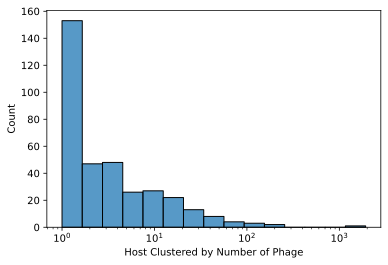

[1925, 216, 164, 113, 110, 97, 84, 78, 73, 71, 56, 53, 52, 52, 52, 38, 37, 35, 31, 30, 30, 28, 27, 26, 25, 24, 24, 23, 22, 22, 22, 20, 20, 19, 19, 18, 18, 17, 17, 17, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 14, 14, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 10, 10, 10, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [11]:
import seaborn as sns
a = l['host'].value_counts().to_numpy()
print(f"{len(l)} pairs of interactions")
print(f"{len(a)} strains of host")
print(f"{np.count_nonzero(a > 1)} strains with more than 1 phage")
print(f"{np.count_nonzero(a > 2)} strains with more than 2 phage")
print(f"{np.count_nonzero(a > 3)} strains with more than 3 phage")
sns.histplot(l['host'].value_counts().to_numpy(), log_scale=True)
plt.xlabel("Host Clustered by Number of Phage")
plt.show()
print(a.tolist())

In [12]:
vals = l['host'].value_counts().to_numpy()
keys = l['host'].value_counts().keys().tolist()

##### Build Host Taxonomy Summary

##### Build Helper Dictionaries
1. A dictionary with key of **accession id** and value of **the list of taxonomy string**
2. A dictionary with key of **taxon node id** and value of **corresponding taxon rank**
3. A dictionary with key of **taxon node name (many aliasing)** and value of **taxon node id**

*nodes.dmp* and *names.dmp* were downloaded from NCBI taxonomy database taxdump.tar.gz

In [28]:
""" A dictionary w/ host id as key and taxonomy as value """
with open("../Host_taxonomy.csv", 'r') as f:
    lines = f.readlines()
    
taxon = {}
for l in lines:
    taxon[l.split(',')[0]] = l.split(',')[1]

In [29]:
""" A dictionary w/ taxon node id and taxon rank """
with open("../taxon//nodes.dmp", "r") as f:
    lines = f.readlines()
    
taxonrank, taxonparent = {}, {}
for l in lines:
    tmp = l.split('|')
    taxonrank[tmp[0].strip()] = tmp[2].strip()
    taxonparent[tmp[0].strip()] = tmp[1].strip()

In [30]:
""" A dictionary w/ taxon node name and taxon node id """
with open("../taxon//names.dmp", "r") as f:
    lines = f.readlines()

taxonid = {}
for l in lines:
    if l.split('|')[1].strip() not in taxonid:
        taxonid[l.split('|')[1].strip()] = l.split('|')[0].strip()

In [31]:
def lookup_name(num):
    names = []
    for i, j in taxonid.items():
        if j == num:
            names.append(i)
    return min(names, key=len)
    #print(f"{min(names, key = len)} has {v} pair of interaction") 

### Visualize Host Distribution Clustered by Taxon Ranks

In [32]:
# rank can be 'superkingdom, phylum, class, order, family, genus' 
rank = 'phylum'
lib  = {}

for k, v in taxon.items():
    exist = False
    t = v.split(';')
    for j in t:
        if taxonrank[taxonid[j.strip()]] == rank:
            exist = True
            lib[taxonid[j.strip()]] = lib.get(taxonid[j.strip()], 0) + vals[keys.index(k)]
    if not exist:
        lowest = j.strip()
        this_n = taxonid[lowest]
        parent = taxonparent[this_n]
        while this_n != parent:
            if taxonrank[parent] == rank:
                exist = True
                #name = lookup_name(parent)
                lib[parent] = lib.get(parent, 0) + vals[keys.index(k)]
                break
            this_n = parent
            parent = taxonparent[this_n]
        if not exist:
            print(f"WARNING: {k} has no expected rank: {rank}")


a = np.array([v for k, v in lib.items()])
print(f"{np.sum(a)} pairs of interactions (exclude hosts w/o this rank)")
print(f"{len(a)} unique {rank} of host")
print(f"{np.count_nonzero(a > 1)} {rank} with more than 1 phage")
print(f"{np.count_nonzero(a > 2)} {rank} with more than 2 phage")
print(f"{np.count_nonzero(a > 3)} {rank} with more than 3 phage")
#sns.histplot(a, log_scale=True, bins=20)
sns.histplot(a, log_scale=True, bins=25)
plt.title(f"{rank} Clustered by its Number of Interactions")
plt.xlabel(f"{rank}")
plt.show()
#print(a)
for k, v in lib.items():
    if v > 5:
        print(f"{lookup_name(k)} has {v} interactions")

4828 pairs of interactions (exclude hosts w/o this rank)
10 unique phylum of host
9 phylum with more than 1 phage
8 phylum with more than 2 phage
8 phylum with more than 3 phage


actinobacteria has 3007 interactions
Bacillota has 766 interactions
proteobacteria has 940 interactions
BCF group has 60 interactions
Cyanophyta has 32 interactions
Mollicutota has 11 interactions


### Generate Negative Sample
To generate negative samples, use generate_neg_samples.ipynb to generate neg_data.csv

Run this cell to do some feature encoding.


In [46]:
table = { 
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M', 
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T', 
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K', 
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                  
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L', 
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P', 
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q', 
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R', 
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V', 
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A', 
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E', 
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G', 
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S', 
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L', 
        'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_', 
        'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W', 
        } 
AA = 'ACDEFGHIKLMNPQRSTVWY*'
print(len(AA))
print(AA.find('*'))

Chemi_stats = {    'A':{'C': 3, 'H': 7, 'O': 2, 'N': 1, 'S': 0},
                   'C':{'C': 3, 'H': 7, 'O': 2, 'N': 1, 'S': 1},
                   'D':{'C': 4, 'H': 7, 'O': 4, 'N': 1, 'S': 0},
                   'E':{'C': 5, 'H': 9, 'O': 4, 'N': 1, 'S': 0},
                   'F':{'C': 9, 'H': 11,'O': 2, 'N': 1, 'S': 0},
                   'G':{'C': 2, 'H': 5, 'O': 2, 'N': 1, 'S': 0},
                   'H':{'C': 6, 'H': 9, 'O': 2, 'N': 3, 'S': 0},
                   'I':{'C': 6, 'H': 13,'O': 2, 'N': 1, 'S': 0},
                   'K':{'C': 6, 'H': 14,'O': 2, 'N': 2, 'S': 0},
                   'L':{'C': 6, 'H': 13,'O': 2, 'N': 1, 'S': 0},
                   'M':{'C': 5, 'H': 11,'O': 2, 'N': 1, 'S': 1},
                   'N':{'C': 4, 'H': 8, 'O': 3, 'N': 2, 'S': 0},
                   'P':{'C': 5, 'H': 9, 'O': 2, 'N': 1, 'S': 0},
                   'Q':{'C': 5, 'H': 10,'O': 3, 'N': 2, 'S': 0},
                   'R':{'C': 6, 'H': 14,'O': 2, 'N': 4, 'S': 0},
                   'S':{'C': 3, 'H': 7, 'O': 3, 'N': 1, 'S': 0},
                   'T':{'C': 4, 'H': 9, 'O': 3, 'N': 1, 'S': 0},
                   'V':{'C': 5, 'H': 11,'O': 2, 'N': 1, 'S': 0},
                   'W':{'C': 11,'H': 12,'O': 2, 'N': 2, 'S': 0},
                   'Y':{'C': 9, 'H': 11,'O': 3, 'N': 1, 'S': 0}
            }
PC = 'CHONS'

inv_table = {v: k for k, v in table.items()}


21
20


### Encode Features

##### Amino Acid Composition & Organic Element Composition & Molecular Weight
This cell can be skipped, because it generates feature files that are included in Google drive for each host / phage.

In [33]:
## The following cells run ML models on the processed data features

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc, f1_score, roc_curve, classification_report
from sklearn.inspection import permutation_importance

In [36]:
df = pd.read_csv("../full_data.csv")[['phage', 'host', 'relation']].to_numpy()
Y = df[:, 2]
info = df[:, 0:2]
X = np.zeros((info.shape[0], 27 * 4))

In [37]:
for i in range(info.shape[0]):
    p = np.load(os.path.join(os.getcwd(), "datanew", "phage", info[i, 0], "protein.ft.npy"))
    m1 = np.average(p, axis=0)
    s1 = np.std(p, axis=0)
    h = np.load(os.path.join(os.getcwd(), "datanew", "host", info[i, 1], "protein.ft.npy"))
    m2 = np.average(h, axis=0)
    s2 = np.std(h, axis=0)
    r = np.concatenate((m1, s1, m2, s2), axis=0)
    X[i, :] = r

In [38]:
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y.astype(int), test_size=0.5, random_state=42)

F1 socre is 0.810605


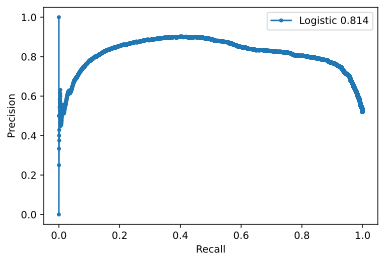

In [39]:
clf = LogisticRegression(random_state=0, max_iter=1e3, tol=1e-5, C=1).fit(X_train, y_train)
precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
f1, prc = f1_score(y_test, clf.predict(X_test)), auc(recall, precision)
plt.plot(recall, precision, marker='.', label=f"Logistic {prc:.3f}")
print(f"F1 socre is {f1:3f}")
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

F1 socre is 0.834279


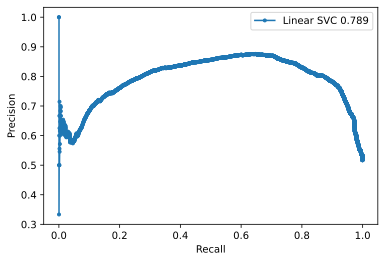

In [40]:
clf = SVC(random_state=0, kernel='linear', probability=True, cache_size=2000).fit(X_train, y_train)
precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
f1, prc = f1_score(y_test, clf.predict(X_test)), auc(recall, precision)
plt.plot(recall, precision, marker='.', label=f"Linear SVC {prc:.3f}")
print(f"F1 socre is {f1:3f}")
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

F1 socre is 0.932193


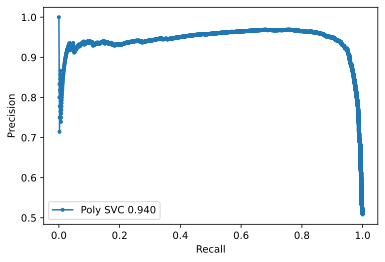

In [41]:
clf = SVC(random_state=0, kernel='poly', degree=2, C=5, probability=True, cache_size=3000).fit(X_train, y_train)
precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
f1, prc = f1_score(y_test, clf.predict(X_test)), auc(recall, precision)
plt.plot(recall, precision, marker='.', label=f"Poly SVC {prc:.3f}")
print(f"F1 score is {f1:3f}")
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

F1 socre is 0.911428


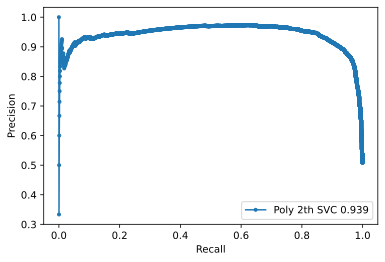

F1 socre is 0.894302


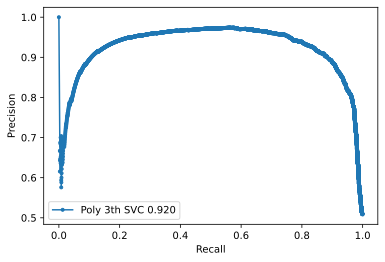

F1 socre is 0.883560


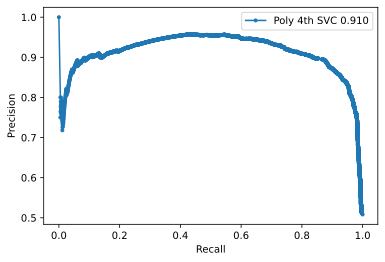

F1 socre is 0.860395


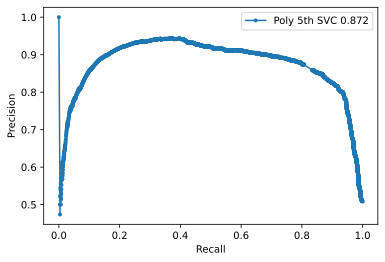

F1 socre is 0.835273


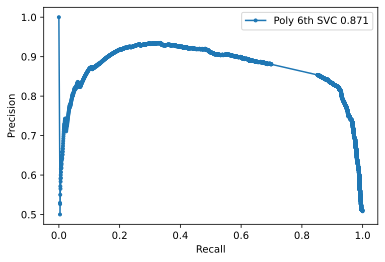

F1 socre is 0.779380


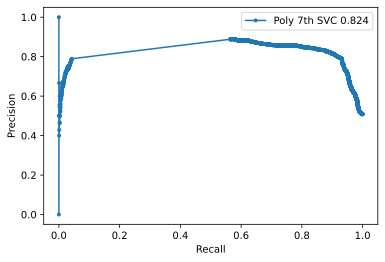

F1 socre is 0.597185


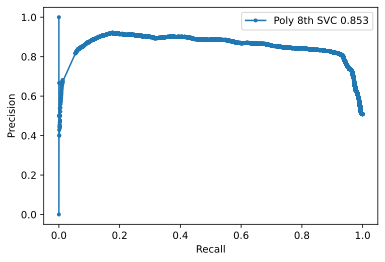

F1 socre is 0.451338


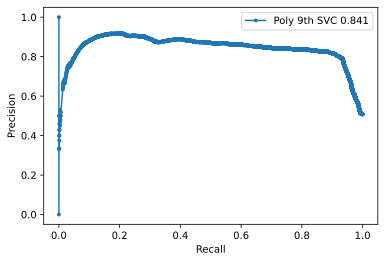

In [42]:
for i in range(2, 10):
    clf = SVC(random_state=0, kernel='poly', degree=i, probability=True, cache_size=3000).fit(X_train, y_train)
    precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    f1, prc = f1_score(y_test, clf.predict(X_test)), auc(recall, precision)
    plt.plot(recall, precision, marker='.', label=f"Poly {i}th SVC {prc:.3f}")
    print(f"F1 socre is {f1:3f}")
    plt.legend()
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.show()

In [43]:
clf = SVC(random_state=0, kernel='rbf', C=1, probability=True, cache_size=3000).fit(X_train, y_train)
precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
f1, prc = f1_score(y_test, clf.predict(X_test)), auc(recall, precision)
plt.plot(recall, precision, marker='.', label=f"RBF SVC {prc:.3f}")
print(f"F1 socre is {f1:3f}")
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

F1 socre is 0.924377


In [44]:
clf = RandomForestClassifier(max_depth=10, min_samples_split=5, random_state=42, warm_start=True, n_estimators=100, n_jobs=-1, min_samples_leaf=2).fit(X_train, y_train)
precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
f1, prc = f1_score(y_test, clf.predict(X_test)), auc(recall, precision)
plt.plot(recall, precision, marker='.', label=f"Poly SVC {prc:.3f}")
print(f"F1 socre is {f1:3f}")
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

F1 socre is 0.940329


              precision    recall  f1-score   support

           0       0.81      0.79      0.80      2374
           1       0.80      0.82      0.81      2453

    accuracy                           0.80      4827
   macro avg       0.80      0.80      0.80      4827
weighted avg       0.80      0.80      0.80      4827

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      2374
           1       0.80      0.87      0.83      2453

    accuracy                           0.82      4827
   macro avg       0.83      0.82      0.82      4827
weighted avg       0.83      0.82      0.82      4827

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2374
           1       0.93      0.93      0.93      2453

    accuracy                           0.93      4827
   macro avg       0.93      0.93      0.93      4827
weighted avg       0.93      0.93      0.93      4827

              preci

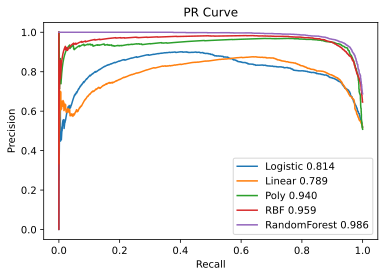

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      2374
           1       0.80      0.82      0.81      2453

    accuracy                           0.80      4827
   macro avg       0.80      0.80      0.80      4827
weighted avg       0.80      0.80      0.80      4827

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      2374
           1       0.80      0.87      0.83      2453

    accuracy                           0.82      4827
   macro avg       0.83      0.82      0.82      4827
weighted avg       0.83      0.82      0.82      4827

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2374
           1       0.93      0.93      0.93      2453

    accuracy                           0.93      4827
   macro avg       0.93      0.93      0.93      4827
weighted avg       0.93      0.93      0.93      4827

              preci

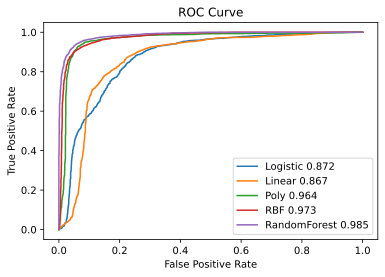

In [50]:
def plot_PRC(clf, y_test, X_test, name):
    precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    prc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} {prc:.3f}")
    print(classification_report(y_test, clf.predict(X_test)))

def plot_ROC(clf, y_test, X_test, name):
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} {roc:.3f}")
    print(classification_report(y_test, clf.predict(X_test)))
    

clf1 = LogisticRegression(random_state=0, max_iter=1e3, tol=1e-5, C=1).fit(X_train, y_train)
clf2 = SVC(random_state=0, kernel='linear', probability=True, cache_size=2000).fit(X_train, y_train)
clf3 = SVC(random_state=0, kernel='poly', degree=2, C=5, probability=True, cache_size=3000).fit(X_train, y_train)
clf4 = SVC(random_state=0, kernel='rbf', C=1, probability=True, cache_size=3000).fit(X_train, y_train)
clf5 = RandomForestClassifier(max_depth=10, min_samples_split=5, random_state=42, warm_start=True, n_estimators=100, n_jobs=-1, min_samples_leaf=2).fit(X_train, y_train)
plot_PRC(clf1, y_test, X_test, 'Logistic')
plot_PRC(clf2, y_test, X_test, 'Linear')
plot_PRC(clf3, y_test, X_test, 'Poly')
plot_PRC(clf4, y_test, X_test, 'RBF')
plot_PRC(clf5, y_test, X_test, 'RandomForest')
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("PR Curve")
plt.show()


plot_ROC(clf1, y_test, X_test, 'Logistic')
plot_ROC(clf2, y_test, X_test, 'Linear')
plot_ROC(clf3, y_test, X_test, 'Poly')
plot_ROC(clf4, y_test, X_test, 'RBF')
plot_ROC(clf5, y_test, X_test, 'RandomForest')
plt.legend()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.show()

In [51]:
c = ["AA-" + i for i in AA] + ["PC-" + i for i in PC] + ['MW']
cols = []
for i in ['P', 'H']:
    for j in ['M', 'S']:
        for k in c:
            cols.append(f"{i}-{j}-{k}")

This cell can be skipped if FeatureImportance.csv is used.

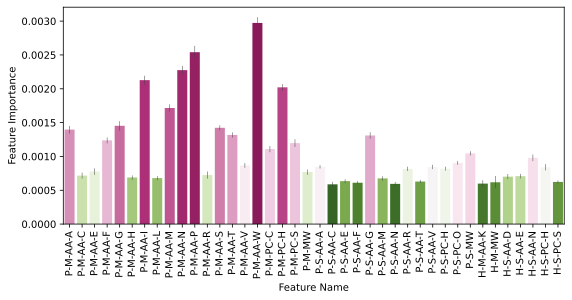

In [54]:
importance = pd.read_csv("../FeatureImportance.csv", index_col=0)

sum_across = importance.sum(axis=0)
num_ft_to_keep = 40
a = sum_across.to_numpy().argsort()[::-1]
threshold = sum_across.keys()[a][num_ft_to_keep]
ft_to_keep = sum_across[sum_across > sum_across[threshold]].keys()
importance = importance[ft_to_keep]

df_feature_long = pd.melt(importance,var_name='feature name', value_name='values')
df_feature_long.head()

# https://stackoverflow.com/questions/36271302/changing-color-scale-in-seaborn-bar-plot
tmp = importance.sum(axis=0)
fig, ax = plt.subplots(figsize=(9, 4))
pal = sns.color_palette("PiYG", len(tmp))
rank = tmp.argsort().argsort()
b = sns.barplot(x="feature name", y="values", data=df_feature_long, order=tmp.index, palette=np.array(pal[::-1])[rank], errwidth=0.5)
c = b.set_xticklabels(b.get_xticklabels(), rotation = 90)
plt.xlabel("Feature Name")
plt.ylabel("Feature Importance")
plt.savefig("RandomForest_FtImpotance.jpg", bbox_inches='tight', pad_inches=0.1, dpi=300)